In [1]:
import tensorflow as tf
import numpy as np
import random
import os
from glob import glob
import time, datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
%load_ext tensorboard

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Checking our Data and Visualizing

You can check my [Data Preprocessing](https://github.com/jjaimwork/Food-Vision-From-Scratch/tree/master) Notebook for and how I managed to generate my dataset.

### Parsing through our data

In [3]:
data_dir = 'Food-Vision-REDO/datasets/all_data_set/'
test_dir = 'Food-Vision-REDO/datasets/all_data_set/test/'
train_dir = 'Food-Vision-REDO/datasets/all_data_set/test/'

for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'Food-Vision-REDO/datasets/all_data_set/'.
There are 10 directories and 0 images in 'Food-Vision-REDO/datasets/all_data_set/test'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\baklava'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\chicken_wings'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\filet_mignon'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\gyoza'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\paella'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\peking_duck'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\sashimi'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\scallops'.
There are 0 directories and 250 images i

### Generating a list of classes

In [4]:
class_list = glob(os.path.join(test_dir, '*',))
class_list = [i.split('\\')[-1] for i in class_list]
class_list

['baklava',
 'chicken_wings',
 'filet_mignon',
 'gyoza',
 'paella',
 'peking_duck',
 'sashimi',
 'scallops',
 'spring_rolls',
 'tuna_tartare']

### Visualizing Random Images

In [5]:
def plot_random_image(class_list, directory):
    
    '''
    Takes in a list of classes which randomly selects an image in its directory
    
    
    Parameters
    --------
    class_list - list of classes(similar to its folder name)
    directory - location of images you would want to view
    '''
    
    random_class = random.choice(class_list)
    random_dir = directory + random_class
    random_img = random.choice(os.listdir(random_dir))
    rng_dir_img = random_dir + '/' + random_img
    arr_dir_img = mpimg.imread(rng_dir_img)
    
    img=plt.imshow(arr_dir_img)
    plt.axis(False)
    plt.title(f'class:{random_class}\n shape:{arr_dir_img.shape}\n {random_img}')
    return img

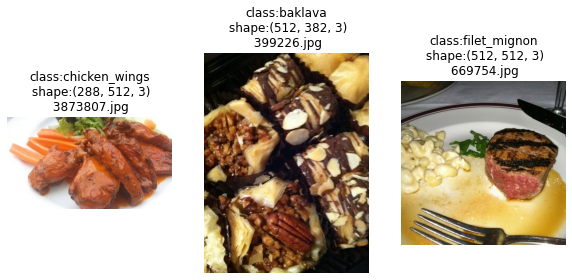

In [6]:
plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.subplot(1,3,i)
    plot_random_image(class_list, test_dir)

## What is a Convolutional Neural Networks and how does it work?

CNNs basically a neural network where for complexities of data in terms of; image and video processing, and it learns and recognizes patterns within that input which is then filtered for `n` amount of times with regards to the problem at hand which in turn uses the `weights(which are the patterns learned)` to help with object detection.

See [CNN Explainer Website](https://poloclub.github.io/cnn-explainer/) a much detailed explanation

Generally a CNN has hyperparameters of the following: 
* **`Input Size`**- the shape of the image in terms of pixel size (h/w)
* **`Padding`** - conserves the outside borders of the image
* **`Kernel Size`** - amount of square windows that will go through the input layer(think of it as generating minibatches) and generates a single window/pixel of condensed weights it has learned
* **`Stride`** - affects the output layer on how much compression of information it sets, can also be affect by the Kernel Size

## Building a CNN Model from Scratch

#### Importing data from directory

In [7]:
# importing our data
train_dir = './Food-Vision-REDO/datasets/all_data_set/train/'
test_dir = './Food-Vision-REDO/datasets/all_data_set/test/'

#### Understanding Callbacks

Callbacks generates functionalities that would deem helpful during or after training, they generate: **logs, checkpoints and also early stopping** which are the most common

**Tensorboard Callback** - generates logs of training files that can be interacted with Tensorboard itself.

**Checkpoint Callback** - generates a checkpoint where it saves incase something happens, this is generally helpful when we're going to train for longer periods to build backups just incase.

In [8]:
# Building a Tensorboard Function

def create_tensorboard_callback(dir_name, experiment_name):
    '''
    creates a tensorboard callback logs file
    
    dirname / logs/fits / experiment_name / datetime
    
    Parameters
    -------
    dir_name - project path name where logs will be stored
    experiment_name - specific name of the model path you'd want to generate
    
    %load_ext tensorboard
    tensorboard --logdir='' --host localhost
    '''
    log_dir = dir_name + '/' + 'logs/fits' + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving Tensorboard logfiles to {log_dir}')
    return tensorboard_callback

In [9]:
checkpoint_path = './Food-Vision-REDO/checkpoint/checkpoint.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch',
    verbose=1
)
    

#### Generating a base model

We'd generally make a base model and try to improve it by beating it throughout each experimentation.

In [10]:
# normalize the rgb values to 0-1
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# creating mini batches of categorical data and reshaping them into 224,224
train_data = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    class_mode='categorical',
    target_size=(224,224) 
)

test_data = test_datagen.flow_from_directory(
    test_dir, 
    batch_size=32,
    class_mode='categorical',
    target_size=(224,224)
)

# building our base model


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [11]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10,3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10,3, activation='relu'),
    tf.keras.layers.Conv2D(10,3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# compiling
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# fitting and saving its history
model_1_history = model_1.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback("./Food-Vision-REDO/transfer_learning", "10_percent_feature_extract")]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning/logs/fits/10_percent_feature_extract/20211112-161921
Epoch 1/5
235/235 [==============================] - 22s 82ms/step - loss: 2.1195 - accuracy: 0.2237 - val_loss: 1.9213 - val_accuracy: 0.3088
Epoch 2/5
235/235 [==============================] - 18s 75ms/step - loss: 1.8116 - accuracy: 0.3644 - val_loss: 1.8461 - val_accuracy: 0.3532
Epoch 3/5
235/235 [==============================] - 17s 73ms/step - loss: 1.5148 - accuracy: 0.4761 - val_loss: 1.8928 - val_accuracy: 0.3368
Epoch 4/5
235/235 [==============================] - 17s 73ms/step - loss: 1.0840 - accuracy: 0.6389 - val_loss: 2.1890 - val_accuracy: 0.3180
Epoch 5/5
235/235 [==============================] - 17s 73ms/step - loss: 0.6054 - accuracy: 0.8064 - val_loss: 2.7769 - val_accuracy: 0.2976


In [12]:
model_1.evaluate(test_data)

79/79 [==============================] - 4s 53ms/step - loss: 2.7769 - accuracy: 0.2976


[2.776869773864746, 0.29760000109672546]

In [13]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [14]:
def plot_history_curves(model):
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    
    accuracy = model.history['accuracy']
    val_accuracy = model.history['val_accuracy']
    
    epochs = range(len(model.history['loss']))
    
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss[lower == better]')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Val Accuracy')
    plt.title('Accuracy[higher==better]')
    plt.xlabel('Epochs')
    plt.legend()

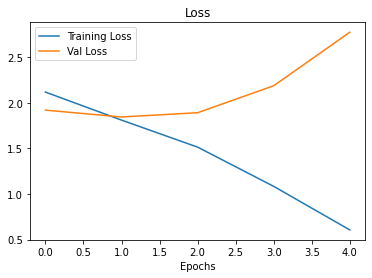

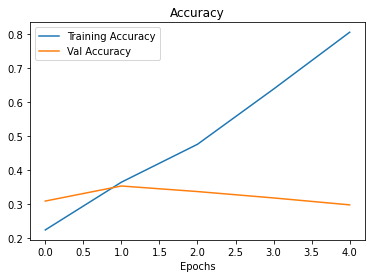

In [15]:
plot_history_curves(model_1_history)

Our model is overfitting.

In [76]:
#tensorboard --logdir='Food-Vision-REDO/transfer_learning/' --host localhost 

### Overcoming Overfitting

Based from the graph above we can say our model is overfitting

Overfitting generally happens when our model **IS** learning on the training set, but doesn't really perform well with the validation set as seen in the graphs.

How to overcome overfitting: 

* **Get more data** - Get more data, having more data == more patterns to learn from. (we already have a wide variety of images)
* **Simplify model** - Overfitting would simply mean literally perfectly or too strong in the training set that its using those memorized features instead of learning and actually applying what it's learned to the test/validation
* **Use Data Augmentation** - Generating different patterns of the image so the model would take a hard time learning as it adds different varieties of patterns to learn from. 
* **Use Transfer Learning** - By utilizing models that have already and been pretrained and use those patterns for our own problems

>  Overfitting happens the Accuracy and Loss separate from each other which would mean using;   

        * needing more data, simplifying the model, augmenting the data, transfer learning 
        
> for Underfitting, our Accuracy and Loss would stick together which would mean using;

        * a stronger model

#### Simplifying the Model

We can simplify our model by reducing each layer within the `Sequential Layer`


In [17]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_2_history = model_2.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
235/235 [==============================] - 18s 75ms/step - loss: 2.1933 - accuracy: 0.2441 - val_loss: 1.9259 - val_accuracy: 0.3192
Epoch 2/5
235/235 [==============================] - 18s 76ms/step - loss: 1.7462 - accuracy: 0.3973 - val_loss: 1.9638 - val_accuracy: 0.3068
Epoch 3/5
235/235 [==============================] - 18s 76ms/step - loss: 1.4604 - accuracy: 0.5123 - val_loss: 1.9365 - val_accuracy: 0.3436
Epoch 4/5
235/235 [==============================] - 17s 73ms/step - loss: 1.1305 - accuracy: 0.6343 - val_loss: 2.1641 - val_accuracy: 0.3036
Epoch 5/5
235/235 [==============================] - 17s 73ms/step - loss: 0.7678 - accuracy: 0.7664 - val_loss: 2.3532 - val_accuracy: 0.3200


In [18]:
model_2.evaluate(test_data)

79/79 [==============================] - 4s 53ms/step - loss: 2.3532 - accuracy: 0.3200


[2.3532352447509766, 0.3199999928474426]

In [19]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 29160)             0         
                                                                 
 dense_1 (Dense)             (None, 10)               

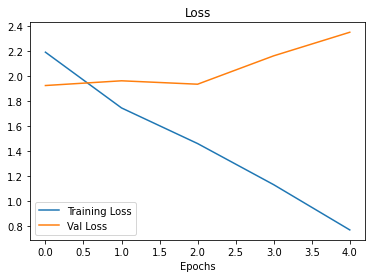

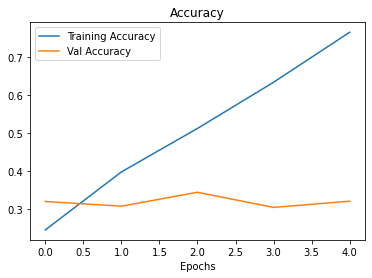

In [20]:
plot_history_curves(model_2_history)

Generally better than our base model, yet our model is still overfitting and not learning any better.

#### Data Augmentation 

`Data Augmentation` is diversifying the images by instead of just seeing it as it is and learning from it; ideally in the real world we view stuff in different perspectives/angles/range which means by increasing the diversity of the images thus would produce a better model to detect images it hasn't seen before.

In [22]:
train_augmented_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_data_augmentmented = train_augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


##### Data Augmentation with CPU

In [23]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_3_history = model_3.fit(
    train_data_augmentmented,
    epochs=5,
    steps_per_epoch=len(train_data_augmentmented),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
235/235 [==============================] - 74s 314ms/step - loss: 2.1473 - accuracy: 0.2103 - val_loss: 1.9825 - val_accuracy: 0.2956
Epoch 2/5
235/235 [==============================] - 74s 315ms/step - loss: 2.0086 - accuracy: 0.2819 - val_loss: 1.9344 - val_accuracy: 0.3208
Epoch 3/5
235/235 [==============================] - 74s 314ms/step - loss: 1.9290 - accuracy: 0.3165 - val_loss: 1.8860 - val_accuracy: 0.3392
Epoch 4/5
235/235 [==============================] - 73s 312ms/step - loss: 1.8870 - accuracy: 0.3328 - val_loss: 1.8357 - val_accuracy: 0.3620
Epoch 5/5
235/235 [==============================] - 74s 313ms/step - loss: 1.8578 - accuracy: 0.3508 - val_loss: 1.8720 - val_accuracy: 0.3600


The training now is generally a lot slower this time since we're using both CPU for data augmentation, and GPU for training the model.

> 🔑 Ideally you'd want to put it on the Sequential layer instead of ImageDataGenerator since the Sequential Layer utilizes the GPU for everything that's inside it.



##### Data Augmentation using GPU

In [24]:
train_dir_10_percent = './Food-Vision-REDO/datasets/10_percent_data_set/train/'

In [25]:
train_10_percent_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir_10_percent,
    image_size=(224,224),
    label_mode="categorical",
    batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=(224,224),
    label_mode="categorical")

Found 1000 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [26]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
], name ="data_augmentation")

In [27]:
resize_and_rescale = tf.keras.Sequential([    
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Resizing(224, 224),
])

In [28]:
model_4 = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.GlobalMaxPool2D(name="global_average_pooling_layer"),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_4_history = model_4.fit(
    train_10_percent_data,
    epochs=5,
    steps_per_epoch=len(train_10_percent_data),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data))
)

Epoch 1/5
32/32 [==============================] - 8s 212ms/step - loss: 2.3122 - accuracy: 0.1000 - val_loss: 2.3020 - val_accuracy: 0.0905
Epoch 2/5
32/32 [==============================] - 7s 209ms/step - loss: 2.3027 - accuracy: 0.1120 - val_loss: 2.2999 - val_accuracy: 0.1151
Epoch 3/5
32/32 [==============================] - 7s 209ms/step - loss: 2.3026 - accuracy: 0.1040 - val_loss: 2.3014 - val_accuracy: 0.1118
Epoch 4/5
32/32 [==============================] - 6s 200ms/step - loss: 2.3022 - accuracy: 0.1060 - val_loss: 2.3017 - val_accuracy: 0.1036
Epoch 5/5
32/32 [==============================] - 7s 210ms/step - loss: 2.3015 - accuracy: 0.1000 - val_loss: 2.2995 - val_accuracy: 0.1118


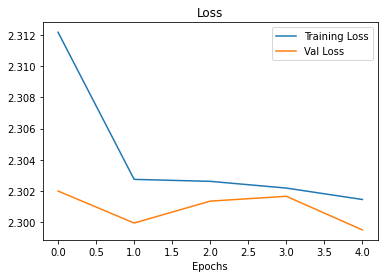

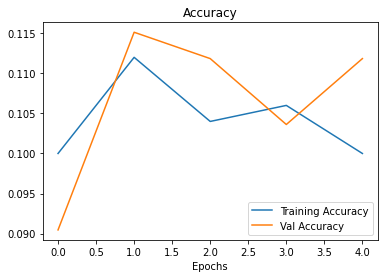

In [29]:
plot_history_curves(model_4_history)

> This is just an example of Data Augmenting with Sequential Layer to utilize the GPU, with the model it runs faster yet there is a much better and flexible way of doing this. Also our model isn't learning due to overfitting, which means our model is too complex(either we remove some of the data augmentations and more experiments) but let's move on for now. 

## CNN Transfer Learning [Feature Extraction]

**Transfer Learning** is using of a pretrained models' configurations from prelearned data and stored weights to solve our problem.

Since building the model and experimenting; trying different configurations our model's layers, adjusting hyperparameters(lr) takes so much time, thus using Transfer Learning will ease up our experimentation process.

this is called **Feature Extraction**

Why use `EfficientNetB0`?

>In general, to get higher accuracy, we need to use a “deeper” or larger model. But a larger model has many more parameters that make it slower to execute. 

>So, this is a balance we need to strike. For most of the Deep Learning deployments in the industry, we choose the smallest model that provides us with good enough accuracy. Thus, we need to experiment among many available models to pick the one that meets these criteria.

>On a side note, if you only care about achieving the highest accuracy no matter the impact to speed, then your approach could be to combine all these models using ensembling techniques! Indeed, ensembling is quite popular in academia and ML competitions.

[How to Choose the Best Keras Pre-Trained Model for Image Classification](https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4)


We're going to follow our model building and experimentation  [taken from MDBourkes slides](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/slides/05_transfer_learning_with_tensorflow_part_2_fine_tuning.pdf) for every model we're building from now on

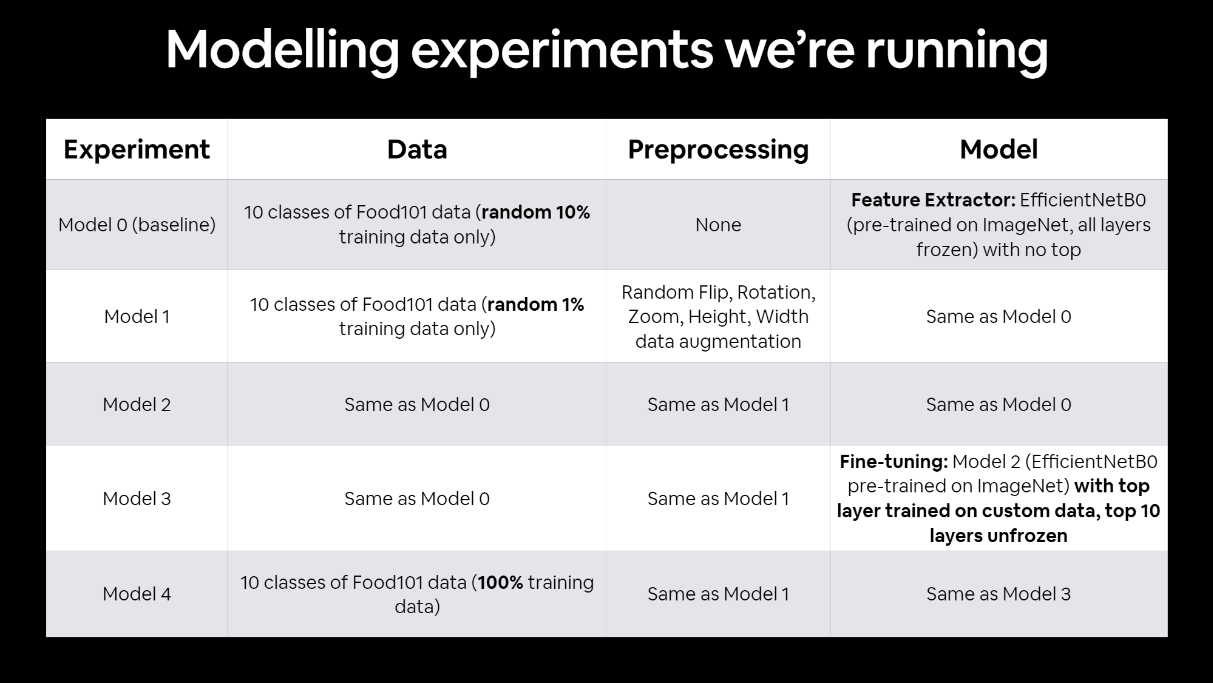

In [30]:
train_dir_10_percent = 'Food-Vision-REDO/datasets/10_percent_data_set/train/' 
train_dir_1_percent = 'Food-Vision-REDO/datasets/1_percent_data_set/train/'
train_data_dir = 'Food-Vision-REDO/datasets/all_data_set/train/'
test_data_dir = 'Food-Vision-REDO/datasets/all_data_set/test/'

Before we used **ImageDataGenerator** which used the CPU for data augmentation then passed-through  
**flow_from_directory** which only parses the images from the directory and is iterated throughout the training

So now we're going to use **image_data_set_from_directory** which in turn generates a dataset and batch files.

> * **flow_from_directory**: <keras.preprocessing.image.DirectoryIterator object at 0x000001294B219550>,  
> * **image_dataset_from_directory**: <BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [31]:
# preparing our data

IMG_SIZE = (224,224)

train_data_all = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_data_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical'
)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir_10_percent,
    image_size = IMG_SIZE,
    label_mode = 'categorical'
)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir_1_percent,
    image_size = IMG_SIZE,
    label_mode = 'categorical'
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_data_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical'
)

Found 7500 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.
Found 100 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Building Model 0 

**Experiment** - Model 0  
**Data** - 10% of the data set  
**Preprocessing** - None  
**Model** - Feature Extraction of a Transfer Learning Model  

In [54]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

tf_model_0 = tf.keras.Model(inputs, outputs)

tf_model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

tf_model_0_history = tf_model_0.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback(
        dir_name='./Food-Vision-REDO/transfer_learning',
        experiment_name='model_0'
    )]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning/logs/fits/model_0/20211112-172928
Epoch 1/5
32/32 [==============================] - 10s 142ms/step - loss: 1.8724 - accuracy: 0.4120 - val_loss: 1.4317 - val_accuracy: 0.6332
Epoch 2/5
32/32 [==============================] - 3s 105ms/step - loss: 1.1560 - accuracy: 0.7260 - val_loss: 1.0905 - val_accuracy: 0.7105
Epoch 3/5
32/32 [==============================] - 3s 107ms/step - loss: 0.8810 - accuracy: 0.7910 - val_loss: 0.9123 - val_accuracy: 0.7533
Epoch 4/5
32/32 [==============================] - 4s 108ms/step - loss: 0.7289 - accuracy: 0.8270 - val_loss: 0.8375 - val_accuracy: 0.7566
Epoch 5/5
32/32 [==============================] - 3s 108ms/step - loss: 0.6310 - accuracy: 0.8470 - val_loss: 0.7928 - val_accuracy: 0.7664


In [55]:
tf_model_0.evaluate(test_data)

79/79 [==============================] - 5s 60ms/step - loss: 0.7853 - accuracy: 0.7752


[0.785335123538971, 0.7752000093460083]

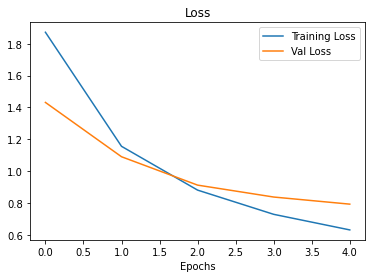

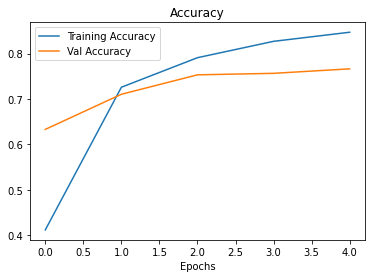

In [56]:
plot_history_curves(tf_model_0_history)

Our Model 0 performed better than our CNN from scratch by only using 10% of the dataset.

####  Building Model 1

**Experiment** - Model 1  
**Data** - 1%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction of a Transfer Learning Model 


In [57]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
    #tf.keras.layers.Rescaling(1./255), # no need for Effnet
])

In [58]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

tf_model_1 = tf.keras.Model(inputs, outputs)

tf_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

tf_model_1_history = tf_model_1.fit(
    train_data_1_percent,
    epochs=5,
    steps_per_epoch=len(train_data_1_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback(
        dir_name='./Food-Vision-REDO/transfer_learning/',
        experiment_name='model_1'
    )]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/model_1/20211112-173000
Epoch 1/5
4/4 [==============================] - 9s 955ms/step - loss: 2.3460 - accuracy: 0.1100 - val_loss: 2.2822 - val_accuracy: 0.1595
Epoch 2/5
4/4 [==============================] - 2s 647ms/step - loss: 2.1252 - accuracy: 0.2100 - val_loss: 2.1987 - val_accuracy: 0.2056
Epoch 3/5
4/4 [==============================] - 2s 629ms/step - loss: 1.9776 - accuracy: 0.3600 - val_loss: 2.0882 - val_accuracy: 0.2862
Epoch 4/5
4/4 [==============================] - 2s 540ms/step - loss: 1.8340 - accuracy: 0.4200 - val_loss: 2.0227 - val_accuracy: 0.3257
Epoch 5/5
4/4 [==============================] - 2s 594ms/step - loss: 1.6509 - accuracy: 0.6300 - val_loss: 1.9571 - val_accuracy: 0.3405


In [59]:
tf_model_1.evaluate(test_data)

79/79 [==============================] - 5s 61ms/step - loss: 1.9406 - accuracy: 0.3684


[1.9406481981277466, 0.3684000074863434]

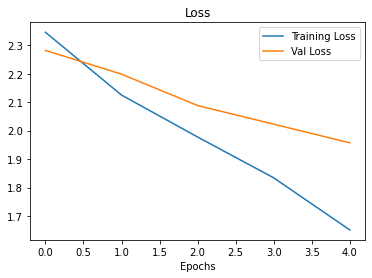

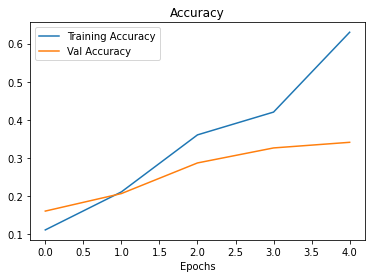

In [60]:
plot_history_curves(tf_model_1_history)

It's 1% of the dataset, yet it's performing okay since it's learning from the augmented data we fed.

####  Building Model 2

**Experiment** - Model 2  
**Data** - 10%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction of a Transfer Learning Model

In [61]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

tf_model_2 = tf.keras.Model(inputs, outputs)

tf_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

tf_model_2_history = tf_model_2.fit(
    train_data_10_percent,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback(
        dir_name='./Food-Vision-REDO/transfer_learning/',
        experiment_name='model_2'
    ), checkpoint_callback]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/model_2/20211112-173024
Epoch 1/5
32/32 [==============================] - ETA: 0s - loss: 2.0129 - accuracy: 0.3150
Epoch 00001: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
32/32 [==============================] - 13s 201ms/step - loss: 2.0129 - accuracy: 0.3150 - val_loss: 1.5655 - val_accuracy: 0.5740
Epoch 2/5
32/32 [==============================] - ETA: 0s - loss: 1.3660 - accuracy: 0.6400
Epoch 00002: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
32/32 [==============================] - 5s 161ms/step - loss: 1.3660 - accuracy: 0.6400 - val_loss: 1.2269 - val_accuracy: 0.6793
Epoch 3/5
32/32 [==============================] - ETA: 0s - loss: 1.1021 - accuracy: 0.7210
Epoch 00003: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
32/32 [==============================] - 5s 155ms/step - loss: 1.1021 - accuracy: 0.7210 - val_loss: 1.0432 - val_accuracy: 0.7237

In [62]:
tf_model_2.evaluate(test_data)

79/79 [==============================] - 5s 64ms/step - loss: 0.8889 - accuracy: 0.7476


[0.8889400362968445, 0.7476000189781189]

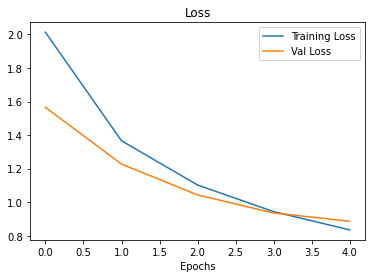

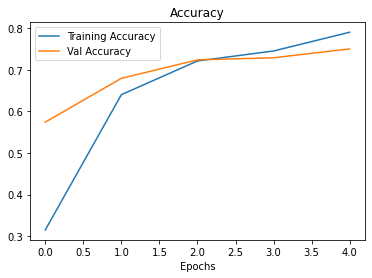

In [63]:
plot_history_curves(tf_model_2_history)

In [64]:
tf_model_2.evaluate(test_data)

79/79 [==============================] - 5s 64ms/step - loss: 0.8889 - accuracy: 0.7476


[0.888940155506134, 0.7476000189781189]

In [65]:
tf_model_2.load_weights(checkpoint_path)

just by using 10% of our dataset and augmenting it, we have reached a huge improvement within the dataset. 

####  Building Model 3

**Experiment** - Model 3   
**Data** - 10%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction + Fine Tuning
**Checkpoint** - From the final epoch of the previous model(tf_model_2)

* make last 10 trainable for `base_model` 
* use `tf_model_2` to compile and fit
* when fitting change `initial epoch` to tf_model_2's final `epoch`
* increase the `epochs` and `learning rate`

> 🔑 When increasing `learning_rate` also increase `epochs`

In [67]:
tf_model_3 = tf_model_2

base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False
    
tf_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

tf_model_3_history = tf_model_2.fit(
    train_data_10_percent,
    epochs=len(tf_model_2_history.epoch)+5,
    initial_epoch=tf_model_2_history.epoch[-1],
    validation_data=test_data,
    validation_steps=int(.25*len(test_data)),
    callbacks=[create_tensorboard_callback(
        dir_name='./Food-Vision-REDO/transfer_learning/',
        experiment_name='model_3'
    ), checkpoint_callback]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/model_3/20211112-173114
Epoch 5/10
32/32 [==============================] - ETA: 0s - loss: 0.7133 - accuracy: 0.8030
Epoch 00005: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
32/32 [==============================] - 14s 206ms/step - loss: 0.7133 - accuracy: 0.8030 - val_loss: 0.7670 - val_accuracy: 0.7632
Epoch 6/10
32/32 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.8130
Epoch 00006: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
32/32 [==============================] - 5s 166ms/step - loss: 0.5790 - accuracy: 0.8130 - val_loss: 0.7352 - val_accuracy: 0.7516
Epoch 7/10
32/32 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.8310
Epoch 00007: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
32/32 [==============================] - 6s 174ms/step - loss: 0.5085 - accuracy: 0.8310 - val_loss: 0.7065 - val_accuracy: 0.7

In [74]:
def compare_history(original_history, new_history, initial_epochs):
    '''
    Input model_2 then new history to show frequency of the train and val loss
    '''
    
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']
    
    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']
    
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']
    
    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']
    
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation History')
    
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

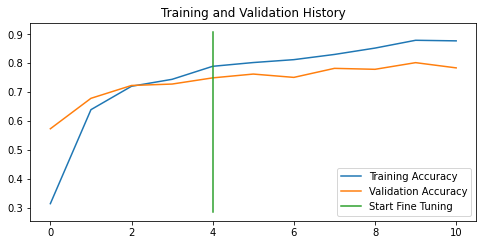

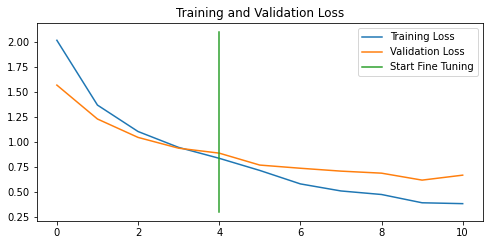

In [69]:
compare_history(tf_model_2_history, tf_model_3_history, initial_epochs=5)

In [ ]:
tf_model_2.evaluate(test_data)

From here we used `tf_model_2`'s previously learned weights, we also turned on training for EfficientNetb0's last 10 layers in the so we could let our model learn/train in those layers, we also increased `learning rate` and `epochs` so we could get more information and have our model learn more. 

####  Building Model 4

**Experiment** - Model 4   
**Data** - 100%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction + Fine Tuning


In [70]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

tf_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=['accuracy'])

tf_model_4_history = tf_model_2.fit(
    train_data_all,
    epochs=len(tf_model_2_history.epoch)+5,
    initial_epoch=tf_model_2_history.epoch[-1],
    validation_data=test_data,
    validation_steps=int(.25*len(test_data)),
    callbacks=[create_tensorboard_callback(
        dir_name='./Food-Vision-REDO/transfer_learning/',
        experiment_name='model_4'
    ), checkpoint_callback]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/model_4/20211112-173155
Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.7756
Epoch 00005: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
235/235 [==============================] - 32s 108ms/step - loss: 0.6976 - accuracy: 0.7756 - val_loss: 0.5131 - val_accuracy: 0.8257
Epoch 6/10
235/235 [==============================] - ETA: 0s - loss: 0.5832 - accuracy: 0.8156
Epoch 00006: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
235/235 [==============================] - 25s 107ms/step - loss: 0.5832 - accuracy: 0.8156 - val_loss: 0.4980 - val_accuracy: 0.8273
Epoch 7/10
235/235 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.8311
Epoch 00007: saving model to ./Food-Vision-REDO/checkpoint\checkpoint.ckpt
235/235 [==============================] - 24s 102ms/step - loss: 0.5260 - accuracy: 0.8311 - val_loss: 0.4695 - val

In [71]:
tf_model_2.evaluate(test_data)

79/79 [==============================] - 5s 62ms/step - loss: 0.4673 - accuracy: 0.8532


[0.4673016667366028, 0.8532000184059143]

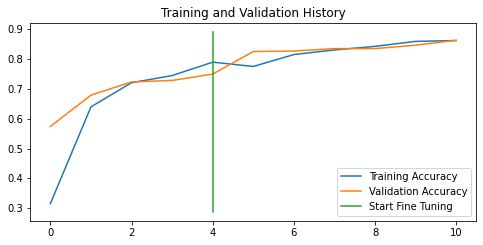

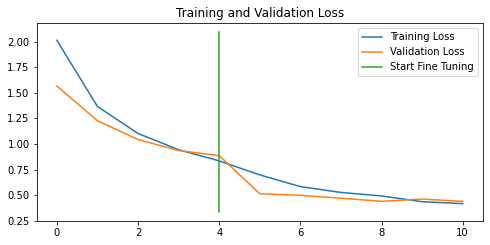

In [73]:
compare_history(tf_model_2_history, tf_model_4_history, initial_epochs=5)

Again we used `tf_model_2`'s prelearned weights, activated training for EfficientNet's last 10 layers, increased the `learning rate` and `epochs` but then we fed it our full dataset which it has learned really well on.

## Scaling Up our CNN Model

In [126]:
train_101_dir = './Food-Vision-REDO/datasets/food_101_10_percent/train/'
test_101_dir = './Food-Vision-REDO/datasets/food_101_10_percent/test/'
food_101_dir = './Food-Vision-REDO/datasets/food_101_10_percent/'

In [120]:
class_list_all = glob(os.path.join(train_101_dir, '*',))
class_list_all = [i.split('\\')[-1] for i in class_list_all]
class_list_all;

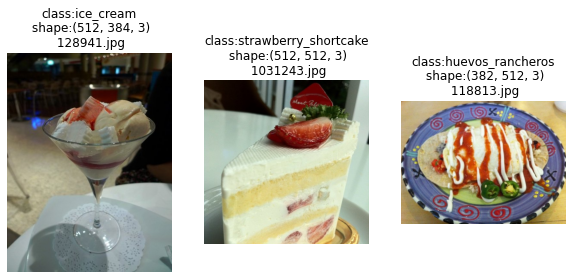

In [124]:
plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.subplot(1,3,i)
    plot_random_image(class_list=class_list_all, directory=train_101_dir)

In [127]:
for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'Food-Vision-REDO/datasets/all_data_set/'.
There are 10 directories and 0 images in 'Food-Vision-REDO/datasets/all_data_set/test'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\baklava'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\chicken_wings'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\filet_mignon'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\gyoza'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\paella'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\peking_duck'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\sashimi'.
There are 0 directories and 250 images in 'Food-Vision-REDO/datasets/all_data_set/test\scallops'.
There are 0 directories and 250 images i